In [1]:
import networkx as nx
import numpy as np
import random
import logging
import matplotlib.pyplot as plt
from tabulate import tabulate
from itertools import product

Global variables

In [2]:
a_allowed = True
a_inv_allowed = True
b_allowed = True
b_inv_allowed = True
c_allowed = True
d_allowed = True
e_allowed = True

N_max = 50 #maximum number of nodes a graph can have, is unlimited if set to -1
n_max = -1 #maximum number of deg3 nodes a graph can have, is unlimited if set to -1

mitograph class

In [3]:
class Mitograph:
    n_max = 50 #maximum number of nodes a graph can have
    def __init__(self, graph, bmap):
        self.bmap = bmap
        self.graph = graph

    # Convenience Functions
    def deg(self, i): return nx.degree(self.graph, i)
    def num_nodes(self): return nx.number_of_nodes(self.graph)
    def num_edges(self,i,j): return self.graph.number_of_edges(i,j)
    def num_con_comp(self): return nx.number_connected_components(self.graph)
    def sort_edge_pair(self,edge_pair): return min(edge_pair), max(edge_pair)
    def new_node_idx(self): return np.array([n for n in nx.nodes(self.graph)]).max()+1
    def edge_list(self): return [key for key in self.bmap]
    def node_list(self): return list(self.graph.nodes())
    def neighbors(self,i): return list(nx.all_neighbors(self.graph,i))
    def copy(self): return Mitograph(self.graph.copy(), self.bmap.copy())
    def neighbors_except(self,i,j):
        neighbors = self.neighbors(i)
        neighbors.remove(j)
        return neighbors
    

    def deg_node_list(self, deg_num): 
        degree_view = nx.degree(self.graph)
        return [node for node, degree in degree_view if degree == deg_num]
    def deg3_node_list(self): return self.deg_node_list(3)
    def deg1_node_list(self): return self.deg_node_list(1)

    #indexing for edges, since multigraph, there be at msot 3 multiedges, so this should suffice

    def edge_indices(self,i,j):
        p,q = self.sort_edge_pair([i,j])
        edge_indices = []
        for key in self.bmap:
            if p == key[0] and q == key[1]: edge_indices.append(key[2])
        return edge_indices
    def max_edge_idx(self,i,j): return max(self.edge_indices(i,j))
    def min_edge_idx(self,i,j): return min(self.edge_indices(i,j))

    def new_edge_idx(self,i,j):
        edge_indices = self.edge_indices(i,j)
        if 0 not in edge_indices: return 0
        elif 1 not in edge_indices: return 1
        else: return 2

    def delete_edge(self,edge, edge_idx= None):
        i,j = self.sort_edge_pair(edge)
        if edge_idx == None: del self.bmap[(i,j,self.max_edge_idx(i,j))]
        else: del self.bmap[(i,j,edge_idx)]
        self.graph.remove_edge(i,j)

        #delete nodes that have no edges connected to them
        del_nodes = [n for n in nx.nodes(self.graph) if self.deg(n)==0 ]
        for n in del_nodes: self.graph.remove_node(n)


    def add_edge(self,edge,dual_edge, return_edge = False):
        i,j = self.sort_edge_pair([edge[0],edge[1]])
        k,l = self.sort_edge_pair(dual_edge)
        new_edge_idx = self.new_edge_idx(i,j)
        self.bmap[(i,j,new_edge_idx)] =  np.array([k,l])
        self.graph.add_edge(edge[0],edge[1])
        if return_edge: return (i,j,new_edge_idx)
   
    def remap_edge(self, edge, dual_edge):
        i,j = self.sort_edge_pair([edge[0],edge[1]])
        k,l = self.sort_edge_pair(dual_edge)
        self.bmap[(i,j,edge[2])] = np.array([k,l])


    def boundary_map(self, i, j, edge_idx):
        i,j = self.sort_edge_pair([i,j])
        return self.bmap[(i,j,edge_idx)]

    def face_map(self, i):
        face = -1
        faces = set([])
        neighbors = self.neighbors(i)
        for j in neighbors:
            dual_edge = list(set(self.boundary_map(i,j,self.min_edge_idx(i,j))))
            if len(dual_edge)==1:faces.add(dual_edge[0])
            else: return face
        if len(faces)==1: face = list(faces)[0]
        return face
       


    def find_face_embedding(self, face, separate = True):
        edge_list = []
        for key in self.bmap:
            if face in self.bmap[key]: edge_list.append(key)
       
        if separate == False:
            return edge_list
        else: 
            boundary_edges, embedded_edges = [],[]
            for edge in edge_list:
                dual_edge = self.bmap[edge]
                if dual_edge[0]==dual_edge[1]: embedded_edges.append(edge)
                else: boundary_edges.append(edge)
            return boundary_edges, embedded_edges 

    class DualGraph:

        def replace_face_in_bmap(self,boundary_edge_list, embedded_edge_list, old_face,new_face):
            for edge in embedded_edge_list:
                self.bmap[edge] = np.array([new_face,new_face])
            for edge in boundary_edge_list:
                dual_edge = self.bmap[edge]
                dual_edge = dual_edge.tolist()
                dual_edge.remove(old_face)
                dual_edge.append(new_face)
                dual_edge.sort()
                self.bmap[edge] = np.array(dual_edge)

        def remove_face(self, old_face, replacement_face):
            old_boundary_edges, old_pendant_edges = self.find_face_embedding(old_face)
            Mitograph.DualGraph.replace_face_in_bmap(self, old_boundary_edges,old_pendant_edges,old_face, replacement_face)


        def find_new_face_nodes(old_face_edges,i,j):
            #take the induced subgraph that is all the edges on the boundary of/embedded in the old face
            old_boundary_subgraph = nx.Graph()
            for key in old_face_edges: old_boundary_subgraph.add_edge(key[0],key[1])
            
            #find smallest cycle containing nodes i and j, this will be one of the boundaries of the new face
            cycle_basis = nx.minimum_cycle_basis(old_boundary_subgraph)
            old_boundary_subgraph.remove_edge(i,j)
            new_boundary_cycle = nx.shortest_path(old_boundary_subgraph,i,j)

            #separate cycles that are joint and disjoint from the boundary nodes cycles
            joint_cycles, disjoint_cycles = [], []
            for cycle in cycle_basis:
                if len(set(cycle) & set(new_boundary_cycle))>0 : joint_cycles.append(cycle)
                else:  disjoint_cycles.append(cycle)

            #joint cycles cannot be on boudnary of or embedded in new face, hence we remove them
            for cycle in joint_cycles:
                removal_nodes = set(old_boundary_subgraph.nodes()) & (set(cycle)-set(new_boundary_cycle))
                old_boundary_subgraph.remove_nodes_from(removal_nodes)

            # the nodes that are on the boundary of and contained in the new face are the nodes of connected component ccontaining node i
            new_embedding_nodes = nx.node_connected_component(old_boundary_subgraph,i)

            #disjoint cycles that are connected to the boundary cycle enclose a face within the new face, and so are added to boundary nodes
            new_boundary_cycle = [new_boundary_cycle]
            for cycle in disjoint_cycles:
                if set(cycle) <= new_embedding_nodes: new_boundary_cycle.append(cycle)

            return  list(new_boundary_cycle), list(new_embedding_nodes)

        def find_new_face_embedding(self,old_face_idx,i,j):

            #find the edges that are on the boundary of and embedded within the old face
            old_face_edges = self.find_face_embedding(old_face_idx, False)

            #find the nodes which form the boundary cycles for the new face, and the nodes which are embedded in the new face
            new_boundary_cycles, new_embedding_nodes = Mitograph.DualGraph.find_new_face_nodes(old_face_edges,i,j)

            #find and return the edges that correspond to the newly found boundary nodes and embedded nodes
            new_boundary_edges, simple_boundary_edges, new_embedded_edges = [], set(), []
            for cycle, edge in product(new_boundary_cycles, old_face_edges):
                p,q = edge[0],edge[1]
                if {p, q}.issubset(cycle) and (p, q) not in simple_boundary_edges:
                    new_boundary_edges.append(edge)
                    simple_boundary_edges.add((p, q))

            for (p, q, edge_idx) in set(old_face_edges) - set(new_boundary_edges):
                if {p, q}.issubset(new_embedding_nodes) and (p, q) not in simple_boundary_edges:
                    if p == q or self.num_edges(p, q) > 1:  new_boundary_edges.append((p, q, edge_idx))
                    else:  new_embedded_edges.append((p, q, edge_idx))
            
            return new_boundary_edges, new_embedded_edges
        
        def add_self_loop_to_bmap(self, i, j, old_face_idx, new_face_idx):
            for q in (i,j):
                if q in self.neighbors(q):
                    dual_edge = self.bmap[(q,q,0)]
                    if dual_edge[0] == dual_edge[1]:
                        self.bmap[(q,q,0)] = np.array([old_face_idx,new_face_idx])

        def add_multiedge_face_to_bmap(self,i,j,old_face_idx,new_face_idx):
            if self.num_edges(i,j)==2:
                for edge_num in self.edge_indices(i,j): 
                    Mitograph.DualGraph.replace_face_in_bmap(self,[(i,j,edge_num)],[],old_face_idx,new_face_idx)
            else: #this is an exceptionally rare case where we have a 3way multiedge (since we have exclusively deg3 and deg1 nodes), but its here
                dual_1 = set(self.bmap[(i,j,0)])
                dual_2 = set(self.bmap[(i,j,1)])
                dual_3 = set(self.bmap[(i,j,2)])
                dual_3.add(new_face_idx)
                faces = list(set.union(dual_1,dual_2,dual_3))
                self.bmap[(i,j,0)] = np.array([faces[0],faces[1]])
                self.bmap[(i,j,1)] = np.array([faces[0],faces[2]])
                self.bmap[(i,j,2)] = np.array([faces[1],faces[2]]) 

        def add_face(self,new_edge, old_face_idx):
            new_face_idx = np.array([self.bmap[key] for key in self.bmap]).max()+1
            i,j = self.sort_edge_pair([new_edge[0],new_edge[1]])
            if i in self.neighbors(i) or j in self.neighbors(j): 
                Mitograph.DualGraph.add_self_loop_to_bmap(self, i, j, old_face_idx, new_face_idx)
            elif self.num_edges(i,j)>1: 
                Mitograph.DualGraph.add_multiedge_face_to_bmap(self,i,j,old_face_idx,new_face_idx)
            else:
                new_boundary_edges, new_embedding_edges = Mitograph.DualGraph.find_new_face_embedding(self, old_face_idx,i,j)
                Mitograph.DualGraph.replace_face_in_bmap(self, new_boundary_edges,new_embedding_edges, old_face_idx,new_face_idx)


    class Display:
    
        def graph(self, title = None):
            fig, ax = plt.subplots()
            nx.draw_planar(self.graph, ax=ax, with_labels = True)
            if title!=None:
                plt.title(title)

        def boundary_map(self):
            for key, value in self.bmap.items():
                print (key, ':', value)

        def embedding_table(self):
            headers = ["face", "edges on boundary of face", "edges contained in face"]
            face_list = []
            for key in self.bmap:
                dual_edge = self.bmap[key]
                if dual_edge[0] not in face_list: face_list.append(dual_edge[0])
                if dual_edge[1] not in face_list: face_list.append(dual_edge[1])
            face_list.sort()
            data = []
            for face in face_list:
                boundary_edges, pendant_edges = self.find_face_embedding(face)
                boundary_edges.sort()
                pendant_edges.sort()
                data.append([face, boundary_edges, pendant_edges])
            print(tabulate(data, headers, tablefmt="grid"))



Demo graph

In [4]:
def load_example_graph():
        #adjacency matrix
        A =np.array([[0,1,1,1,0,0],
               [1,0,1,0,1,0],
               [1,1,0,1,0,0],
               [1,0,1,0,0,1],
               [0,1,0,0,0,0],
               [0,0,0,1,0,0]])
        nx_graph = nx.from_numpy_array(A, parallel_edges=True, create_using = nx.MultiGraph)
        #Boundary map 
        #key: edge in mitochondria graph, (source node, target node, edge index if multiple)
        #value: corresponding edge in dual graph
        bmap={(0,1,0):np.array([0,2]),
          (0,2,0):np.array([0,1]),
          (0,3,0):np.array([1,2]),
          (1,2,0):np.array([0,2]),
          (1,4,0):np.array([2,2]),
          (2,3,0):np.array([1,2]),
          (3,5,0):np.array([2,2])}
        M = Mitograph(nx_graph,bmap)
        return M

def load_I_tubule():
        A = np.array([[0,1],
                        [1,0]])
        nx_graph = nx.from_numpy_array(A, parallel_edges=True, create_using = nx.MultiGraph)
        bmap = {(0,1,0):np.array([0,0])}
        M= Mitograph(nx_graph,bmap)
        return M



Find Possible Transitions

In [5]:
class PossibleTransitions:
    # (most of) the necessary and sufficient conditions for each transition 
    #(not all conditions included in these methods for optimization)
    def a_possible(M):  return True
    def a_inv_possible(M, i, j): return M.num_edges(i,j)==0 and M.face_map(i) == M.face_map(j)
    def b_inv_possible(M,i,j):  return M.deg(i)==1 and M.deg(j)==3  and M.num_edges(i,j)==1 and M.num_nodes()>2
    def c_possible (M, edge,k): return M.deg(k)==1 and (M.face_map(k) in M.bmap[edge]) 
    def d_possible(M,i,j): return M.deg(i) == 1 and M.deg(j)==1 and M.num_nodes()>2
    def e_possible(d_ii1, d_ii2, d_jj1, d_jj2):
        return  not ((len(d_ii1 & d_ii2 & d_jj1 & d_jj2) == 0) and 
                (len(d_ii1 & d_ii2 & d_jj1)>0 or
                len(d_ii1 & d_ii2 & d_jj2)>0  or 
                len(d_ii1 & d_jj1 & d_jj2)>0 or 
                len(d_ii2 & d_jj1 & d_jj2)>0)) 
    
    if N_max>=0:
        def a_possible(M):  return  M.num_nodes()<=N_max-2
        def b_possible(M):  return  M.num_nodes()<=N_max-2
    if n_max>=0:
        def b_possible(M):  return  M.num_nodes()<=n_max-1
        def c_possible (M, edge,k): return M.deg(k)==1 and (M.face_map(k) in M.bmap[edge]) and M.num_nodes()<=n_max-1

    
    def find_a(M,edge_list):
        possible_actions = []
        if PossibleTransitions.a_possible(M):
            for edge in edge_list:
                possible_actions.append(('a',(edge[0],edge[1],edge[2])))               
        return possible_actions

    def find_a_inv(M, deg1_node_list):
        possible_actions = []
        for m in range(len(deg1_node_list)):
            for n in range(m,len(deg1_node_list)):
                i,j = deg1_node_list[m], deg1_node_list[n]
                if i!=j and PossibleTransitions.a_inv_possible(M,i,j):
                    possible_actions.append(('a_inv',(i,j)))
        
        return possible_actions

    def find_b(M, edge_list):  
        possible_actions = []
        if PossibleTransitions.b_possible(M):
            for edge in edge_list:
                dual_edge = M.boundary_map(edge[0],edge[1],edge[2])
                possible_actions.append(('b',(edge[0],edge[1],edge[2],0)))
                if dual_edge[0] != dual_edge[1]:
                    possible_actions.append(('b',(edge[0],edge[1],edge[2],1)))
        
        return possible_actions

    def find_b_inv(M, edge_list):
        possible_actions = []
        for edge in edge_list:
            if PossibleTransitions.b_inv_possible(M,edge[0],edge[1]):
                possible_actions.append(('b_inv',(edge[0],edge[1])))
            elif PossibleTransitions.b_inv_possible(M,edge[1],edge[0]):
                possible_actions.append(('b_inv',(edge[1],edge[0])))
        return possible_actions

    def find_c(M, edge_list, deg1_node_list):
        possible_actions = []
        for edge in edge_list:
            for k in deg1_node_list:
                if  PossibleTransitions.c_possible(M,edge,k):
                    possible_actions.append(('c',(edge[0],edge[1],edge[2],k)))
        return possible_actions   

    def find_d(M, edge_list):
        possible_actions = []
        for edge in edge_list:
            if PossibleTransitions.d_possible(M,edge[0],edge[1]):
                possible_actions.append(('d',(edge[0],edge[1])))
        
        return possible_actions

    def find_e(M, edge_list):
        possible_actions = []
        for edge in edge_list:
            i,j = edge[0],edge[1]
            if  i!=j and M.deg(i)==3 and M.deg(j)==3 and M.num_edges(i,j)==1:
                i_1,i_2 = min(M.neighbors_except(i,j)), max(M.neighbors_except(i,j))
                j_1,j_2 = min(M.neighbors_except(j,i)), max(M.neighbors_except(j,i))
                d_ii1 = set(M.boundary_map(i,i_1,M.min_edge_idx(i,i_1)))
                d_ii2 = set(M.boundary_map(i,i_2,M.max_edge_idx(i,i_2)))
                d_jj1 = set(M.boundary_map(j,j_1,M.min_edge_idx(j,j_1)))
                d_jj2 = set(M.boundary_map(j,j_2,M.max_edge_idx(j,j_2)))
                if PossibleTransitions.e_possible(d_ii1, d_ii2, d_jj1, d_jj2):
                    possible_actions.append(('e',(edge, i_1,i_2,j_1,j_2)))
        return possible_actions

    def find_all(M):
        edge_list = M.edge_list()
        deg1_node_list = M.deg1_node_list()
        transitions = [('do nothing',(0))]
        if a_allowed:     transitions = transitions + PossibleTransitions.find_a(M,edge_list)
        if a_inv_allowed: transitions = transitions + PossibleTransitions.find_a_inv(M,deg1_node_list)
        if b_allowed:     transitions = transitions + PossibleTransitions.find_b(M,edge_list)
        if b_inv_allowed: transitions = transitions + PossibleTransitions.find_a(M,edge_list)
        if c_allowed:     transitions = transitions + PossibleTransitions.find_c(M,edge_list, deg1_node_list)
        if d_allowed:     transitions = transitions + PossibleTransitions.find_d(M,edge_list)
        if e_allowed:     transitions = transitions + PossibleTransitions.find_e(M,edge_list)
        return transitions

Perform Transitions

In [6]:
class Transition:
    def a(M, i, j, edge_idx): 
        dual_edge = M.boundary_map(i,j,edge_idx)
        k,l = min(dual_edge), max(dual_edge)
        n =  M.new_node_idx()

        M.add_edge([i, n], [k,k])
        M.add_edge([j, n+1],[k,k])
        M.delete_edge([i,j],edge_idx)
        if  k!=l: Mitograph.DualGraph.remove_face(M,l,k)
        
        return M

    def a_inv(M, i, j):  
        i1 = M.neighbors(i)[0]
        j1 = M.neighbors(j)[0]
        f = M.face_map(i)
        num_con_comp = M.num_con_comp()
       
        new_edge = M.add_edge([i1,j1], [f, f], return_edge = True)
        M.delete_edge([i,i1])
        M.delete_edge([j,j1])
        if M.num_con_comp()==num_con_comp: 
            Mitograph.DualGraph.add_face(M,new_edge, f)  
        
        return M

    def b(M, i, j, edge_idx,f): #outgrow new edge from edge (i,j,edge_idx) into face f
        dual_edge = M.boundary_map(i,j,edge_idx)
        face = dual_edge[f]
        n = M.new_node_idx()
        
        M.add_edge([i,n], dual_edge)
        M.add_edge([j,n], dual_edge)
        M.add_edge((n,n+1), [face,face])
        M.delete_edge((i,j),edge_idx)
        
        return M

    def b_inv(M, i , j):
        j_1, j_2 = min(M.neighbors_except(j,i)), max(M.neighbors_except(j,i))
        dual_edge = M.boundary_map(j, j_1, M.min_edge_idx(j,j_1))
        
        M.add_edge([j_1,j_2],dual_edge)
        M.delete_edge([i,j])
        M.delete_edge([j,j_1])
        M.delete_edge([j,j_2])
        
        return M

    def c(M, i, i1, edge_idx, j):
        dual_edge = M.boundary_map(i,i1,edge_idx)
        j1 = M.neighbors(j)[0]; 
        f = M.face_map(j)
        num_con_comp = M.num_con_comp()
        
        M.add_edge([i,j],dual_edge)
        M.add_edge([i1,j],dual_edge)
        M.delete_edge([i,i1],edge_idx) 
        if M.num_con_comp() == num_con_comp:
            Mitograph.DualGraph.add_face(M,(j,j1,M.min_edge_idx(j,j1)),f) 

        return M 

    def d(M,i,j):
        M.delete_edge([i,j])
        return M

    def e(M,edge, i_1,i_2,j_1,j_2):
        i,j= edge[0],edge[1]
        dual_i_i1 = M.boundary_map(i,i_1,M.min_edge_idx(i,i_1))
        dual_i_i2 = M.boundary_map(i,i_2,M.max_edge_idx(i,i_2))
        dual_j_j1 = M.boundary_map(j,j_1,M.min_edge_idx(j,j_1))
        dual_j_j2 = M.boundary_map(j,j_2,M.max_edge_idx(j,j_2))    
        
        M.add_edge([i_1,j],dual_i_i1)
        M.delete_edge([i,i_1], M.min_edge_idx(i,i_1))         
        
        alpha = len(set(dual_i_i1) & set(dual_j_j1))
        beta = len(set(dual_i_i1) & set(dual_j_j2)) 
        if dual_j_j1[0]==dual_j_j1[1] and alpha==1: alpha = alpha+1 #to handle case where jj1 or jj2 are pendant edges and ii1 is a pendant edge
        if dual_j_j2[0]==dual_j_j2[1] and beta==1: beta = beta+1
       
       # remember to addd explanation of this line of code and how it handles the case where i1, j1, and j2 are on boundary of same face
        # it simplifies to the following expression when you do all possible cases of how many faces the edges can have in common
        if alpha >= beta: #then nodes i1 and j1 are on the boundary of the same face
            M.add_edge([i,j_2],dual_j_j2)
            M.delete_edge([j,j_2],M.max_edge_idx(j,j_2))
        else: #then nodes i1 and j2 are on boundary of same face
            M.add_edge([i,j_1],dual_j_j1)
            M.delete_edge([j,j_1],M.min_edge_idx(j,j_1))
          
        
        face_i_i1_i2 = list(set(dual_i_i1) & set(dual_i_i2) )
        face_j_j1_j2 = list(set(dual_j_j1) & set(dual_j_j2))

        if len(face_i_i1_i2)==1 and len(face_j_j1_j2)==1:   new_face_1, new_face_2 = face_i_i1_i2[0], face_j_j1_j2[0]
        elif len(face_i_i1_i2)==2 and len(face_j_j1_j2)==1: new_face_1, new_face_2 = face_i_i1_i2[0], face_i_i1_i2[1]        
        elif len(face_i_i1_i2)==1 and len(face_j_j1_j2)==2: new_face_1, new_face_2 = face_j_j1_j2[0], face_j_j1_j2[1]
        elif len(face_i_i1_i2)==2 and len(face_j_j1_j2)==2:
            old_face =  set(dual_i_i1) & set(dual_i_i2) & set(dual_j_j1) & set(dual_j_j2)
            new_face_1 = list((set(dual_i_i1) & set(dual_i_i2)) - old_face )[0]
            new_face_2 = list((set(dual_j_j1) & set(dual_j_j2)) - old_face )[0]

        k,l = M.sort_edge_pair([new_face_1,new_face_2])
        M.remap_edge(edge,[k,l])
            
        return M
    
    def perform(transition_arg,M):
        action_string = transition_arg[0]
        arg = transition_arg[1]
        if   action_string == 'a':     return Transition.a(M,arg[0],arg[1],arg[2])
        elif action_string == 'a_inv': return Transition.a_inv(M,arg[0],arg[1])
        elif action_string == 'b':     return Transition.b(M,arg[0],arg[1],arg[2],arg[3])
        elif action_string == 'b_inv': return Transition.b_inv(M, arg[0],arg[1])
        elif action_string == 'c':     return Transition.c(M,arg[0],arg[1],arg[2],arg[3])
        elif action_string == 'd':     return Transition.d(M,arg[0],arg[1])
        elif action_string == 'e':     return Transition.e(M,arg[0],arg[1],arg[2],arg[3],arg[4])
        elif action_string == 'do nothing': return M


Demonstration of Random Walker

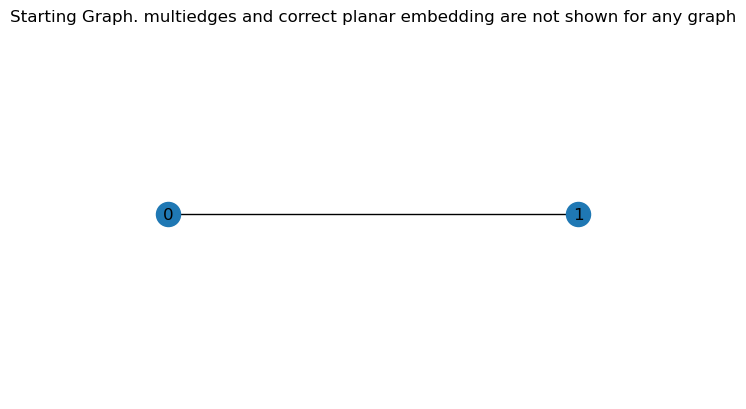

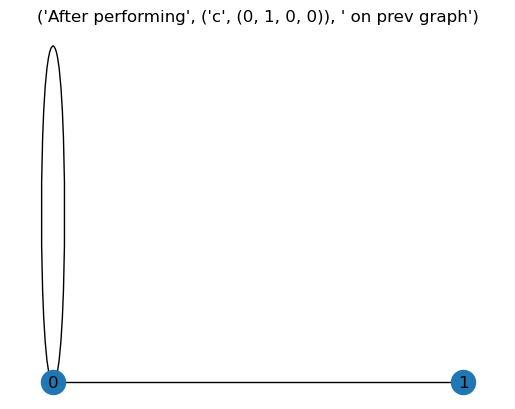

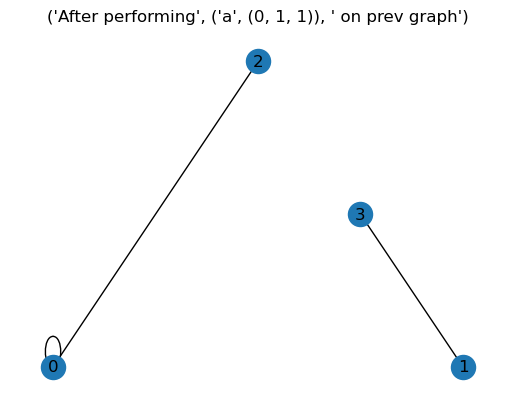

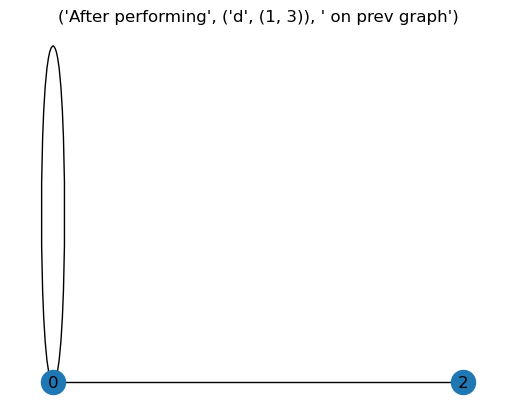

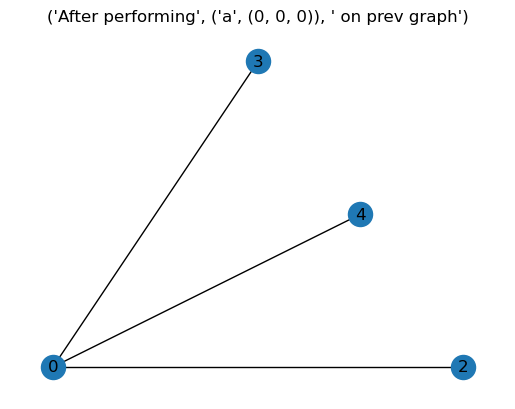

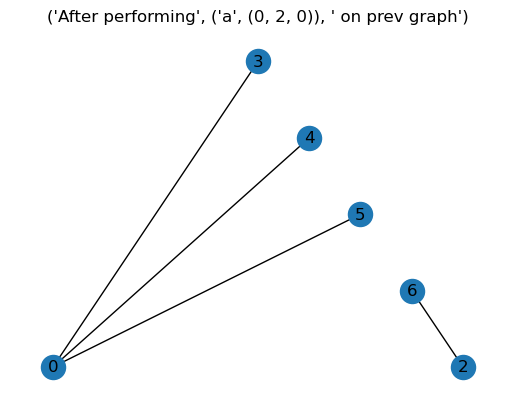

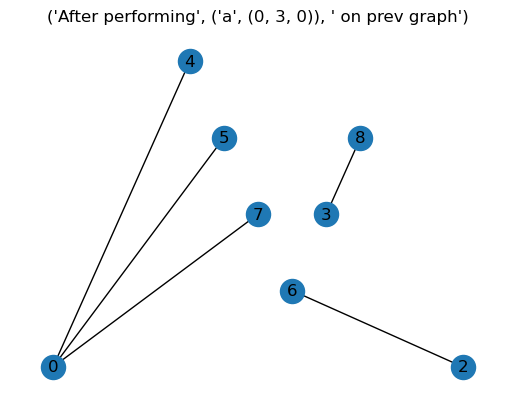

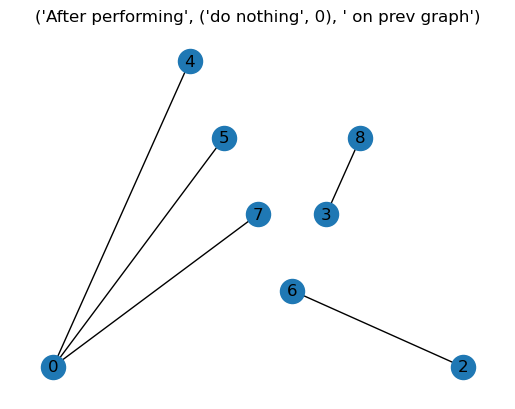

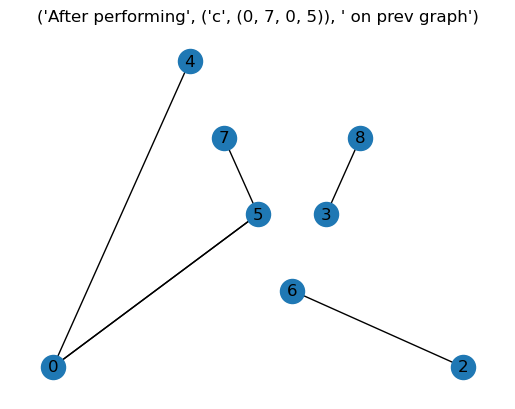

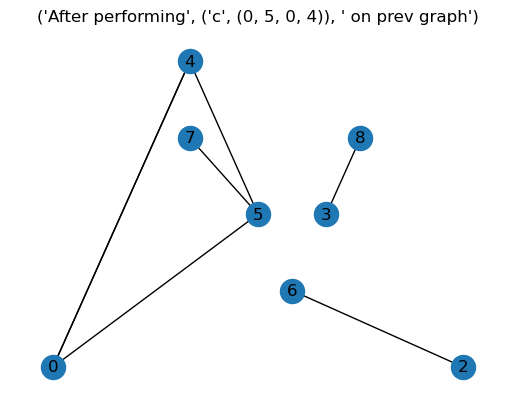

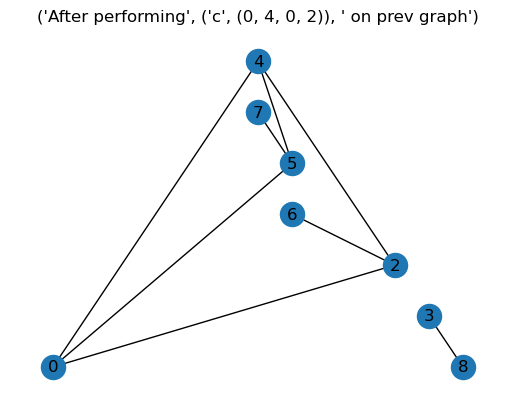

In [7]:
def perform_random_walk(current_state, num_time_steps, store_path = True, store_transitions = True):
    if store_path: path = [current_state.copy()]
    else: path = current_state
    if store_transitions: path_transitions = [('Starting Graph')]
    else: path_transitions = None
    
    for _ in range(num_time_steps):
        possible_transitions = PossibleTransitions.find_all(current_state)
        next_transition = random.choice(possible_transitions)
        Transition.perform(next_transition,current_state)
        
        if store_path: path.append(current_state.copy())
        if store_transitions: path_transitions.append(next_transition)
    
    return path, path_transitions

def display_random_walk(walk, walk_transitions):
    for step in range(len(walk)):
        M = walk[step]
        transition = walk_transitions[step]
        if step!=0: 
            Mitograph.Display.graph(M,('After performing', transition,' on prev graph'))
        else:
            Mitograph.Display.graph(M, ('Starting Graph. multiedges and correct planar embedding are not shown for any graph'))

walk, walk_transitions = perform_random_walk(load_I_tubule(), 10)
display_random_walk(walk,walk_transitions)
        

Measure Failure Rate

In [10]:
def measure_failure_rate(num_trials, walk_length):
    num_fails = 0
    for _ in range(num_trials): 
        try:
            perform_random_walk(load_I_tubule(),walk_length, False, False)
        except:
            num_fails = num_fails+1
    print('failure rate:', 100*(num_fails/num_trials), '%') 

measure_failure_rate(200,100)

failure rate: 6.0 %


Random Walker That is Used for Experiments

In [ ]:
def random_walk(starting_state, walk_length):
    num_fails = 0
    completed_walk = False
    while completed_walk == False:
        try:
            path, transitions = perform_random_walk(starting_state.copy(),walk_length,True,False)
            completed_walk = True
        except:  num_fails = num_fails+1
    return path, num_fails

Debugging Tools

In [9]:
# if the random walker hits a bug, it will show you all the steps it took before hitting bug
def show_steps_to_reproduce_error(transitions):
            print('To reproduce error, perform following set of transitions: ')
            print('path_transitions = [')
            for transition in transitions: print(transition, ",")
            print(']')

def has_misembedding(current_state):
    simple_subgraph = nx.Graph(current_state.graph)
    cycle_basis = nx.cycle_basis(simple_subgraph)
    _,embedded_edges = current_state.find_face_embedding()
    for edge in embedded_edges:
        for cycle in cycle_basis:
            for node_idx in range(len(cycle)-1):
                    if (edge[0]==cycle[node_idx] and edge[1]==cycle[node_idx+1]) or (edge[1]==cycle[node_idx] and edge[0]==cycle[node_idx+1]):
                        return edge              
    return (0)

def test_random_walk(current_state, num_time_steps):
    path_transitions = [('do nothing',(0))]
    for step in range(num_time_steps):
        try: 
            possible_transitions = PossibleTransitions.find_all(current_state)
            next_transition = random.choice(possible_transitions)
            Transition.perform(next_transition, current_state)
            path_transitions.append(next_transition) 
        except:
            print('unable to perform transition: ', next_transition, ' at step: ', step)
            show_steps_to_reproduce_error(path_transitions)
            raise
        # check for errors that violate planarity, and see where are conditions fail
        if nx.is_planar(current_state.graph) == False:
            print('created nonplanar graph after performing: ', next_transition, ' at step: ', step)
            show_steps_to_reproduce_error(path_transitions)
            return 
        #check for edges that become improperly imbedded
        edge = has_misembedding(current_state)
        if len(edge)==3:
            print( 'edge ',edge,' became misembedded after performing: ', next_transition, ' at step: ', step)
            show_steps_to_reproduce_error(path_transitions)
        
    return path_transitions


#use this to run a set of transitions that lead to a bug in order to reproduce it
def reproduce_error(current_state, path_transitions):
    path = []
    for step in range(len(path_transitions)):
        next_transition = path_transitions[step]
        try:
            Transition.perform(next_transition, current_state)
            path.append(current_state.copy())
        except:
            logging.error('unable to perform transition')
            return path, step
    return path, step

def inspect_graph(path,path_transitions,step):
    Mitograph.Display.embedding_table(path[step])
    Mitograph.Display.graph(path[step],path_transitions[step])
